In [1]:
!pip install kaggle


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d !kaggle datasets download -d dataset-owner/dataset-name



usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: unrecognized arguments: download


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:49<00:00, 24.2MB/s]
100% 2.29G/2.29G [01:49<00:00, 22.6MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use tensorflow.keras instead of just keras
from sklearn.utils import class_weight
import math
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
base_dir = '/content/chest_xray/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [8]:
# variables for counting the number of images for each class
pos = 0
neg = 0
train_normal = os.path.join(train_dir, 'NORMAL')
train_disease = os.path.join(train_dir, 'PNEUMONIA')
for path in os.listdir(train_normal):
    if os.path.isfile(os.path.join(train_normal, path)):
        pos += 1
for path in os.listdir(train_disease):
    if os.path.isfile(os.path.join(train_disease, path)):
        neg += 1

In [9]:
test_normal = os.path.join(test_dir, 'NORMAL')
test_disease = os.path.join(test_dir, 'PNEUMONIA')
for path in os.listdir(test_normal):
    if os.path.isfile(os.path.join(test_normal, path)):
        pos += 1
for path in os.listdir(test_disease):
    if os.path.isfile(os.path.join(test_disease, path)):
        neg += 1


In [10]:
validation_normal = os.path.join(val_dir, 'NORMAL')
validation_disease = os.path.join(val_dir, 'PNEUMONIA')
for path in os.listdir(validation_normal):
    if os.path.isfile(os.path.join(validation_normal, path)):
        pos += 1
for path in os.listdir(validation_disease):
    if os.path.isfile(os.path.join(validation_disease, path)):
        neg += 1
print(pos, neg)

1583 4273


In [11]:
def dataGen(img_size, batch_size, seed):

    train_datagen = ImageDataGenerator(rescale = 1./255,rotation_range = 15,width_shift_range = 0.1,height_shift_range = 0.1,shear_range = 0.1,zoom_range = 0.1,
                                       brightness_range = (0.95, 1.05),vertical_flip = False,horizontal_flip = False,fill_mode = 'nearest')
    test_datagen = ImageDataGenerator(rescale = 1./255)
    val_datagen = ImageDataGenerator(rescale = 1./255)

    train_generator = train_datagen.flow_from_directory(train_dir,target_size = (img_size, img_size),batch_size = batch_size,class_mode = 'binary',shuffle = True,seed = seed)

    test_generator = test_datagen.flow_from_directory(test_dir,target_size = (img_size, img_size),batch_size = batch_size,class_mode = 'binary',shuffle = True,seed = seed)

    val_generator = val_datagen.flow_from_directory(val_dir,target_size = (img_size, img_size),batch_size = batch_size,class_mode = 'binary',shuffle = True,seed = seed)

    class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(train_generator.classes), y = train_generator.classes)
    class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
    return train_generator, test_generator, val_generator, class_weights



In [12]:
def plot_acc_loss():
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history['precision']
    recall = history.history['recall']
    epochs_range = range(len(accuracy))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, 'b', label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, 'r', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, precision, 'r', label='Precision')
    plt.plot(epochs_range, recall, 'b', label='Recall')
    plt.legend(loc='best')
    plt.title('Precision and Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall vs Precision')

    plt.tight_layout()

    plt.show()

In [13]:
def decay(lr):
    def decay_fn(epoch):
        return lr * 0.1 ** (epoch / 15)
    return decay_fn
decay_fn = decay(0.02)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(decay_fn)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)


In [14]:
# %%
IMAGE_SIZE = [299, 299]
batch_size = 128
seed = 42


In [15]:
# Preprocessing
train_generator, test_generator, val_generator, class_weights = dataGen(IMAGE_SIZE[0], batch_size, seed)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [16]:
# %%
initial_bias = np.log([pos/neg])
initial_bias

array([-0.99299438])

In [17]:
# %%
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block


In [18]:
# %%
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block


In [19]:
# %%
model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 299, 299, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 299, 299, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 74, 74, 32)          │           2,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 37, 37, 64)          │           7,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 18, 18, 128)         │          27,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 9, 9, 256)           │         103,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 4, 4, 128)           │          53,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 512)                 │       1,051,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 128)                 │          66,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 64)                  │           8,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,953 (5.04 MB)

 Trainable params: 1,319,329 (5.03 MB)

 Non-trainable params: 2,624 (10.25 KB)

In [20]:
# %%
# Set the training parameters
METRICS = ['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')]
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = METRICS)


In [21]:
EPOCHS = 40
# Train the model
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples//test_generator.batch_size,
                    class_weight=class_weights,
                    callbacks=[lr_scheduler, early_stopping],
                    verbose=1)
model.save('pneumonia.keras')

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 279s 5s/step - accuracy: 0.5743 - loss: 0.7409 - precision: 0.8200 - recall: 0.5406 - val_accuracy: 0.3730 - val_loss: 31.1821 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0200
Epoch 2/40
 1/40 ━━━━━━━━━━━━━━━━━━━━ 17s 449ms/step - accuracy: 0.8516 - loss: 0.3760 - precision: 0.9213 - recall: 0.8723

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 575ms/step - accuracy: 0.8516 - loss: 0.3760 - precision: 0.9213 - recall: 0.8723 - val_accuracy: 0.3929 - val_loss: 24.2492 - val_precision: 1.0000 - val_recall: 0.0145 - learning_rate: 0.0172
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.8861 - loss: 0.2938 - precision: 0.9640 - recall: 0.8810 - val_accuracy: 0.4805 - val_loss: 1.2902 - val_precision: 0.8171 - val_recall: 0.2107 - learning_rate: 0.0147
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8984 - loss: 0.2656 - precision: 0.9770 - recall: 0.8854 - val_accuracy: 0.4375 - val_loss: 1.5283 - val_precision: 0.7647 - val_recall: 0.1806 - learning_rate: 0.0126
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.9003 - loss: 0.2518 - precision: 0.9652 - recall: 0.8957 - val_accuracy: 0.6211 - val_loss: 1.0547 - val_precision: 0.6195 - val_recall: 0.9904 - learning_rate: 0.0108
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9531 - loss

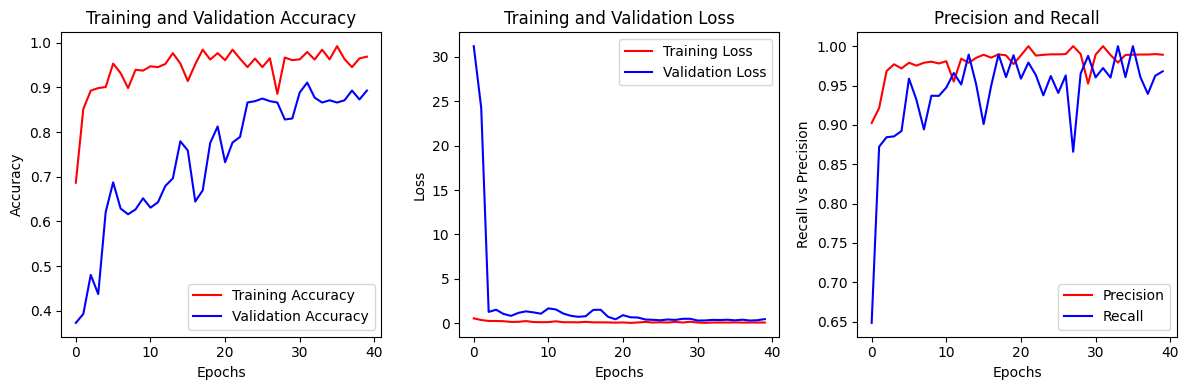

In [22]:
# %%
plot_acc_loss()